# Purpose of Notebook
The goal of this code is to:
- Create models for predicting mass for APOGEE using a set of parameters:
    - Effective Temperature
    - Log g
    - Iron Abundance [Fe/H]
    - Alpha Abundance [alpha/Fe]
    - Nitrogen Abundance [N/Fe]
    - Oxygen Abundance [O/Fe]
- The model will be created using two datasets

- Use APOKSAC model to predict mass for APOGEE

A good question is: why do all of this?
- Although the datasets used have their own mass prediction model, they are for general purposes
- Since we are interested specifically in low mass stars up to 2.5 solar masses, we want more specific prediction of the stars masses
- After using the model, we should also compare the distribution predicted by both models to see if the different models predict similar distribution of masses

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# APOKSAC Model
First, we seperate the data into a set of data used for training and one for verifying the fit out the model

In [2]:
# Import the data
mass_prediction_apoksac = pd.read_csv("ProcessedData/mass_prediction_apoksac.csv")

In [3]:
# The parameters we will be using to create the model
features = ["teff", "logg", "fe_h", "alpha_m", "c_fe", "n_fe", "o_fe"]
# X = data Y = mass
X = mass_prediction_apoksac[features]
y = mass_prediction_apoksac["mass"]

In [4]:
# Using 80% of the data to train the model and use 20% to verify it
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## Random Forest Regression (RFR)
The first model we will use to predict the mass is Random Forest Regression.
We will need to access the fit of our model.
To do this, we will assess the mean squared error (square rooted) and correlation coefficient.

Initial parameters to create the model:
- `n_estimator = 200`
- `train_size = 0.8`
    - 80% of the data is used to train while 20% of the data is used to test the accuracy of the model

In [5]:
# Create the model
seed = 0 # Make sure results are replicable
apk_model_RFR = RandomForestRegressor(n_estimators=500, random_state=seed)
apk_model_RFR.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=0)

Now that we have created the model, we will use test data to verify that the model has been tuned correctly.

In [6]:
y_pred_RFR = apk_model_RFR.predict(X_test)
# Determine whether the model
score_RFR = np.sqrt(mean_absolute_error(y_pred_RFR, y_test))
corr_RFR = np.corrcoef(y_test, y_pred_RFR)[0][1]

`score_RFR` represents the mean difference between predicted value and actual value.
It can be calculated using the following
$$ RMSE = \sqrt{
\frac{
    \sum_{i=1}^N (\hat{y}_i - y_i)^2
    }
    {N}
}
$$


In [7]:
score_RFR

0.3427101334347873

In [8]:
corr_RFR

0.8861482537907972

Now that we have used our model, below will show a graphical representation of how the data differs from the actual data.

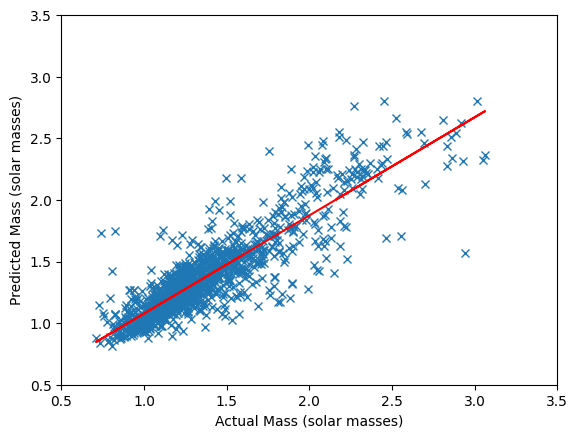

In [9]:
plt.plot(y_test, y_pred_RFR, 'x')
plt.xlabel("Actual Mass (solar masses)")
plt.ylabel("Predicted Mass (solar masses)")
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)

theta = np.polyfit(y_test, y_pred_RFR, 1)
least_square_regression_line = theta[1] + theta[0] * y_test
plt.plot(y_test, least_square_regression_line, "r-")

Comparing the distribution of masses using histograms.

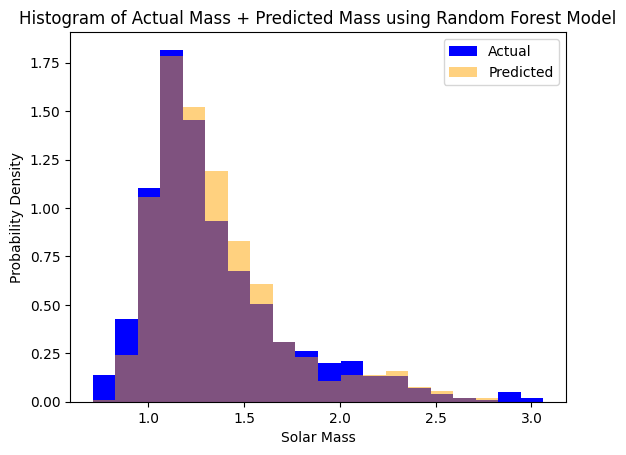

In [10]:
_, mass_bins = np.histogram(y_test, bins = 20)
plt.hist(y_test, density=True, color="blue", bins=mass_bins)
plt.hist(y_pred_RFR, density=True, color="orange", alpha=0.5, bins=mass_bins)
plt.ylabel("Probability Density")
plt.xlabel("Solar Mass")
plt.title("Histogram of Actual Mass + Predicted Mass using Random Forest Model")
plt.legend(("Actual", "Predicted" ), loc="upper right")

As shown above, the model is much better are predicting mass that are lower than 2 Solar Masses.
- This is related to the limitation of RFR as it is generally heavily dependent on its training set.
    - However, it is worth noting that this study is interested in stars below 2.5 solar masses, so the accuracy past 2.5 solar masses may be forgiven.
- Due to the lack of high mass stars in the training set, the model is unable to extrapolate past the more common, low mass stars.
- The model tends of underestimate mass
    - Model predict more masses around the 1 - 1.5 solar mass range while predicting less exceeding 2.75 solar masses or less than 1 solar mass.

After experimenting with the parameters (specifically `n_estimators`, increasing the number of estimators yields a more accurate result for most masses except for low mass stars (less than 1 solar mass)
- There is hence a trade-off which we will make to make the model overestimate mass of very low mass stars (<1 solar masses) and underestimate mass of high mass stars (>2 solar masses)

## Polynomial Regression (PR)
The second model we will use to predict the mass is polynomial regression.
While this model runs into the problem of some assumptions not being satisfied such as the need for variables to be independent (mass/log gravity is typically correlated with things such as effective temperature) and the parameters not being additive, it is nonetheless a standard model worth using.

The code is largely inspired by [Data36 guide](https://data36.com/polynomial-regression-python-scikit-learn/)

In [11]:
# Create the model
poly = PolynomialFeatures(degree=7, include_bias=False)
poly_features_train = poly.fit_transform(X_train[features])
apk_model_PR = LinearRegression()

In [12]:
# Train the model
apk_model_PR.fit(poly_features_train, y_train)

LinearRegression()

In [13]:
# Test the model
poly_features_test = poly.fit_transform(X_test[features])
y_pred_PR = apk_model_PR.predict(poly_features_test)

In [14]:
score_PR = np.sqrt(mean_absolute_error(y_pred_PR, y_test))
score_PR

0.35931999689102156

In [15]:
corr_PR = np.corrcoef(y_test, y_pred_PR)[0][1]
corr_PR

0.8499002030635

ways of representing data and howInitial parameters to create the model:
- `degree = 7`
    - We are using 7 different parameters.

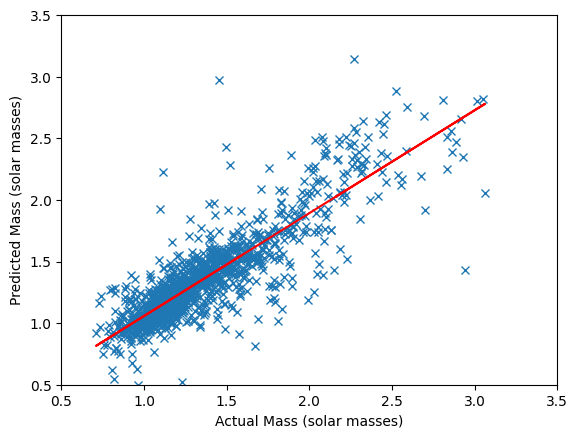

In [16]:
plt.plot(y_test, y_pred_PR, 'x')
plt.xlabel("Actual Mass (solar masses)")
plt.ylabel("Predicted Mass (solar masses)")
plt.xlim(0.5, 3.5)
plt.ylim(0.5, 3.5)

theta = np.polyfit(y_test, y_pred_PR, 1)
least_square_regression_line = theta[1] + theta[0] * y_test
plt.plot(y_test, least_square_regression_line, "r-")

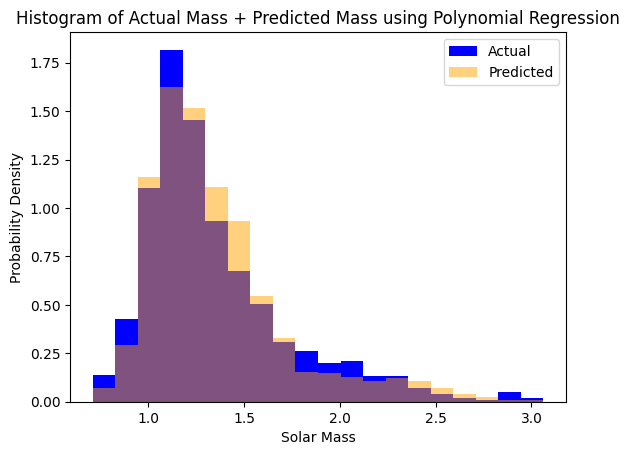

In [17]:
_, mass_bins = np.histogram(y_test, bins = 20)
plt.hist(y_test, density=True, color="blue", bins=mass_bins)
plt.hist(y_pred_PR, density=True, color="orange", alpha=0.5, bins=mass_bins)
plt.ylabel("Probability Density")
plt.xlabel("Solar Mass")
plt.title("Histogram of Actual Mass + Predicted Mass using Polynomial Regression")
plt.legend(("Actual", "Predicted" ), loc="upper right")

# Mass for Deep Mixing Prediction

Append a new column to existing APOGEE data that records the mass

In [20]:
apogee = pd.read_csv("ProcessedData/cleaned_apogee.csv")
params = apogee[features]
params = params.dropna()
mass_apogee = apk_model_RFR.predict(params)
apogee["mass"] = mass_apogee

In [21]:
apogee.to_csv("ProcessedData/apogee_with_mass.csv", index=False)

## Analysis of Mass Prediction

Text(0.5, 0, 'Mass in solar masses')

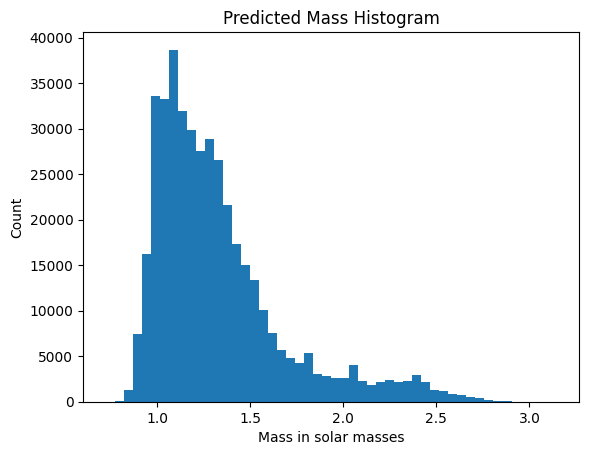

In [22]:
plt.hist(
    apogee.mass,
    bins = 50
)

plt.title("Predicted Mass Histogram")
plt.ylabel("Count")
plt.xlabel("Mass in solar masses")

In [23]:
apogee.mass.describe()

count    419056.000000
mean          1.325415
std           0.353193
min           0.723010
25%           1.077262
50%           1.237808
75%           1.449683
max           3.146064
Name: mass, dtype: float64

Text(0, 0.5, 'Predicted Mass')

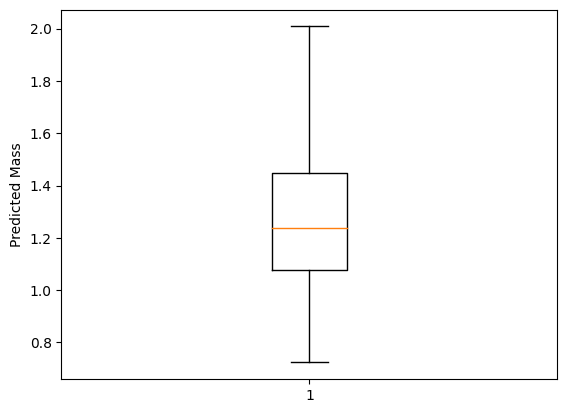

In [24]:
plt.boxplot(
    apogee.mass,
    showfliers=False
)
plt.ylabel("Predicted Mass")

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0236de17f0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f023710a280>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0236ec5220>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0236ec55e0>}

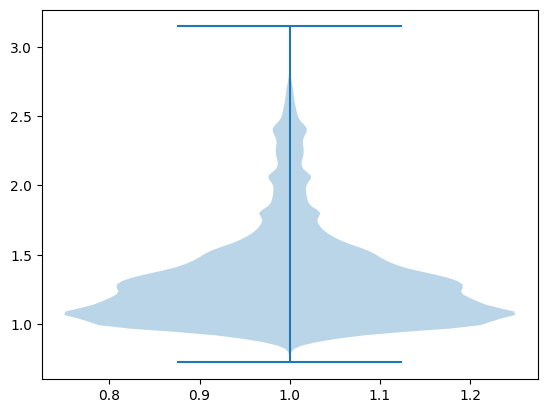

In [25]:
plt.violinplot(apogee.mass)